CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=25, bias=True)
)
Epoch 1: Train Acc=0.2335, Val Acc=0.6662, Train Loss=2.5235, Val Loss=1.2943
✅ Model improved and saved.
Epoch 2: Train Acc=0.5592, Val Acc=0.8115, Train Loss=1.3149, Val Loss=0.7046
✅ Model improved and saved.
Epoch 3: Train Acc=0.6699, Val Acc=0.8785, Train Loss=0.9581, Val Loss=0.4679
✅ Model improved and saved.
Epoch 4: Train Acc=0.7303, Val Acc=0.9293, Train Loss=0.7737, Val Loss=0.3099
✅ Model improved and saved.
Epoch 5: Train Acc=0.7743, Val Acc=0.9561, Train Loss=0.6329, Val Loss=0.2087
✅ Model improved and saved.
Epoch 6: Train Acc=0.8068, Val Acc=0.9683, Train Loss=0.5416, Val Loss=0.1606
✅ Model impr

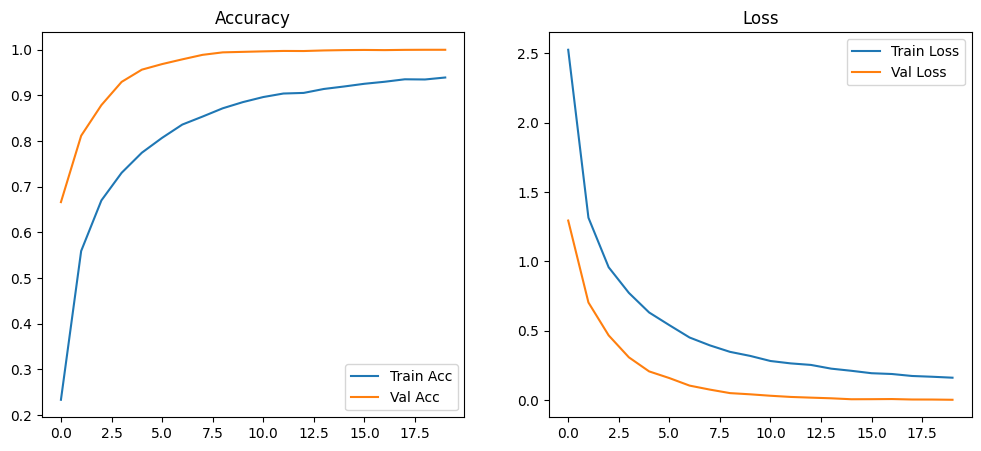

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

# ==============================
# 1. Завантаження даних
# ==============================
train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

Y_train = train_df['label'].values
X_train = train_df.drop('label', axis=1).values

Y_test = test_df['label'].values
X_test = test_df.drop('label', axis=1).values

# ==============================
# 2. Попередня обробка
# ==============================
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 1, 28, 28).astype(np.float32)
X_test = X_test.reshape(-1, 1, 28, 28).astype(np.float32)

Y_train = Y_train.astype(np.int64)
Y_test = Y_test.astype(np.int64)

# ==============================
# 3. Torch Dataset + Split
# ==============================
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(Y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ==============================
# 4. CNN модель
# ==============================
class CNN(nn.Module):
    def __init__(self, num_classes=25):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # після двох пулингів (28→13→5)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

# ==============================
# 5. Оптимізатор і функція втрат
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==============================
# 6. Навчання з Early Stopping
# ==============================
best_val_acc = 0.0
patience = 5
counter = 0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(20):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Validation ----
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_loss = running_loss / total
    val_acc = correct / total

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # ---- Early Stopping + Save best model ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model improved and saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹ Early stopping triggered.")
            break

# ==============================
# 7. Оцінка на тесті
# ==============================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        correct += (preds == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"\n✅ Test accuracy: {test_acc:.4f}")

# ==============================
# 8. Візуалізація
# ==============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()
